In [1]:
import sys
import os
# Add src directory to path
sys.path.append("../../src")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.helpers_news_movies import *

from nltk.corpus import stopwords
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import dask.dataframe as dd
import torch 


/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ddf = dd.read_parquet('../../data/nyt_data.parquet')
# Filter dataset for a particular range
filtered_ddf = ddf[(ddf['year'] >= 1965) & (ddf['year'] <= 2015)]
# Reduce the dataset
filtered_ddf = filtered_ddf.sample(frac=0.01, random_state=1)
filtered_ddf = filtered_ddf.reset_index(drop=True)
# Combine the text and process it
filtered_ddf['combined_text'] = filtered_ddf['title'] + filtered_ddf['excerpt']
filtered_ddf['processed_text'] = filtered_ddf['combined_text'].apply(preprocess_text, meta=('processed_text', 'str'), args= ('stop_words_',))


In [4]:
print(filtered_ddf.head())
print(filtered_ddf.shape[0].compute())

   year                                              title  \
0  1968  Harris Upham & Co: Fed judge, San Francisco, o...   
1  2002  Integra Realty Resources reports Houston, site...   
2  2009  Electric cars and a smart electric grid have a...   
3  1986  The Castelwood Corporation, Jenkintown, Pa., t...   
4  2002  James Scott Lives column describes how Hunting...   

                                             excerpt  \
0  over 10,000 transactions were made in 6 yrs, 1...   
1  reports downtown office vacancy rate of 10 per...   
2                                                      
3             Another Publication For New Homeowners   
4  his brothers Randy and Andy became so ill and ...   

                                       combined_text  \
0  Harris Upham & Co: Fed judge, San Francisco, o...   
1  Integra Realty Resources reports Houston, site...   
2  Electric cars and a smart electric grid have a...   
3  The Castelwood Corporation, Jenkintown, Pa., t...   
4  James S

In [5]:
# Load the model
model_miniLM = SentenceTransformer("all-MiniLM-L6-v2")

In [6]:
# Load embedding or compute if not available

if os.path.exists('news_embeddings.npy'):
    news_embeddings = np.load('news_embeddings.npy')
    news_embeddings = torch.tensor(news_embeddings).to('mps')

else:
    news_embeddings = model_miniLM.encode(filtered_ddf['processed_text'].compute(), show_progress_bar=True, convert_to_tensor=True)
    np.save('news_embeddings.npy', news_embeddings.to('cpu').numpy())

print(news_embeddings.shape)

torch.Size([75109, 384])


In [7]:
# Raw queries to encode
# Queries
VIETNAM_WAR = "Vietnam"
COLD_WAR = "USSR"
IRAK_WAR = "Irak"
WW2 = "World War 2"
TECHNOLOGY = "technology"
ECONOMY = "economy"
HEALTH = "health"
GENDER_EQUALITY = "gender equality"
MIGRATION = "migration"

# Encode queries
query_vietnam = torch.tensor(model_miniLM.encode([VIETNAM_WAR])).to('mps')
query_cold_war = torch.tensor(model_miniLM.encode([COLD_WAR])).to('mps')
query_irak_war = torch.tensor(model_miniLM.encode([IRAK_WAR])).to('mps')
query_ww2 = torch.tensor(model_miniLM.encode([WW2])).to('mps')

query_technology = torch.tensor(model_miniLM.encode([TECHNOLOGY])).to('mps')
query_economy = torch.tensor(model_miniLM.encode([ECONOMY])).to('mps')
query_health = torch.tensor(model_miniLM.encode([HEALTH])).to('mps')
query_gender_equality = torch.tensor(model_miniLM.encode([GENDER_EQUALITY])).to('mps')
query_migration = torch.tensor(model_miniLM.encode([MIGRATION])).to('mps')

queries = [query_vietnam, query_cold_war, query_irak_war, query_ww2, query_technology, query_economy, query_health, query_gender_equality, query_migration]
column_names = ['vietnam', 'cold_war', 'irak_war', 'ww2', 'technology', 'economy', 'health', 'gender_equality', 'migration']

In [8]:
# Create a dataframe to store the cosine similarity
cosine_similarity_df = pd.DataFrame(columns=column_names)
# Add the index to the dataframe
cosine_similarity_df['index'] = filtered_ddf.index.compute()

# Compute cosine similarity for each query
for i, query in enumerate(queries):
    similarity = torch.nn.functional.cosine_similarity(news_embeddings, query)
    cosine_similarity_df[column_names[i]] = similarity.to('cpu').numpy()

# Add the year to the dataframe
cosine_similarity_df['year'] = filtered_ddf['year'].compute()
print(cosine_similarity_df.head())
print(cosine_similarity_df.shape)



    vietnam  cold_war  irak_war       ww2  technology   economy    health  \
0 -0.003818 -0.011560  0.051369 -0.033218    0.045777  0.159008 -0.028729   
1  0.072826  0.066510  0.164120  0.042381    0.153809  0.224839  0.045519   
2 -0.078234 -0.002882  0.069937 -0.016565    0.155093  0.118617  0.016836   
3 -0.034968 -0.069356  0.086707  0.007350    0.090013  0.043544  0.030298   
4  0.041140  0.031129  0.057620  0.094910    0.099847  0.016751  0.140677   

   gender_equality  migration  index  year  
0         0.052591   0.023000      0  1968  
1         0.086419   0.137164      1  2002  
2        -0.010067   0.074017      2  2009  
3         0.027364   0.121876      3  1986  
4         0.055706   0.060617      4  2002  
(75109, 11)


In [9]:
# Save the dataframe
cosine_similarity_df.to_csv('cosine_similarity_news.csv', index=True)
# Make a boolean version of the dataframe with a threshold of 0.3
cosine_similarity_df_bool = cosine_similarity_df.copy()
cosine_similarity_df_bool = cosine_similarity_df_bool.drop(columns=['index', 'year'])
cosine_similarity_df_bool = cosine_similarity_df_bool > 0.2
cosine_similarity_df_bool['year'] = cosine_similarity_df['year']


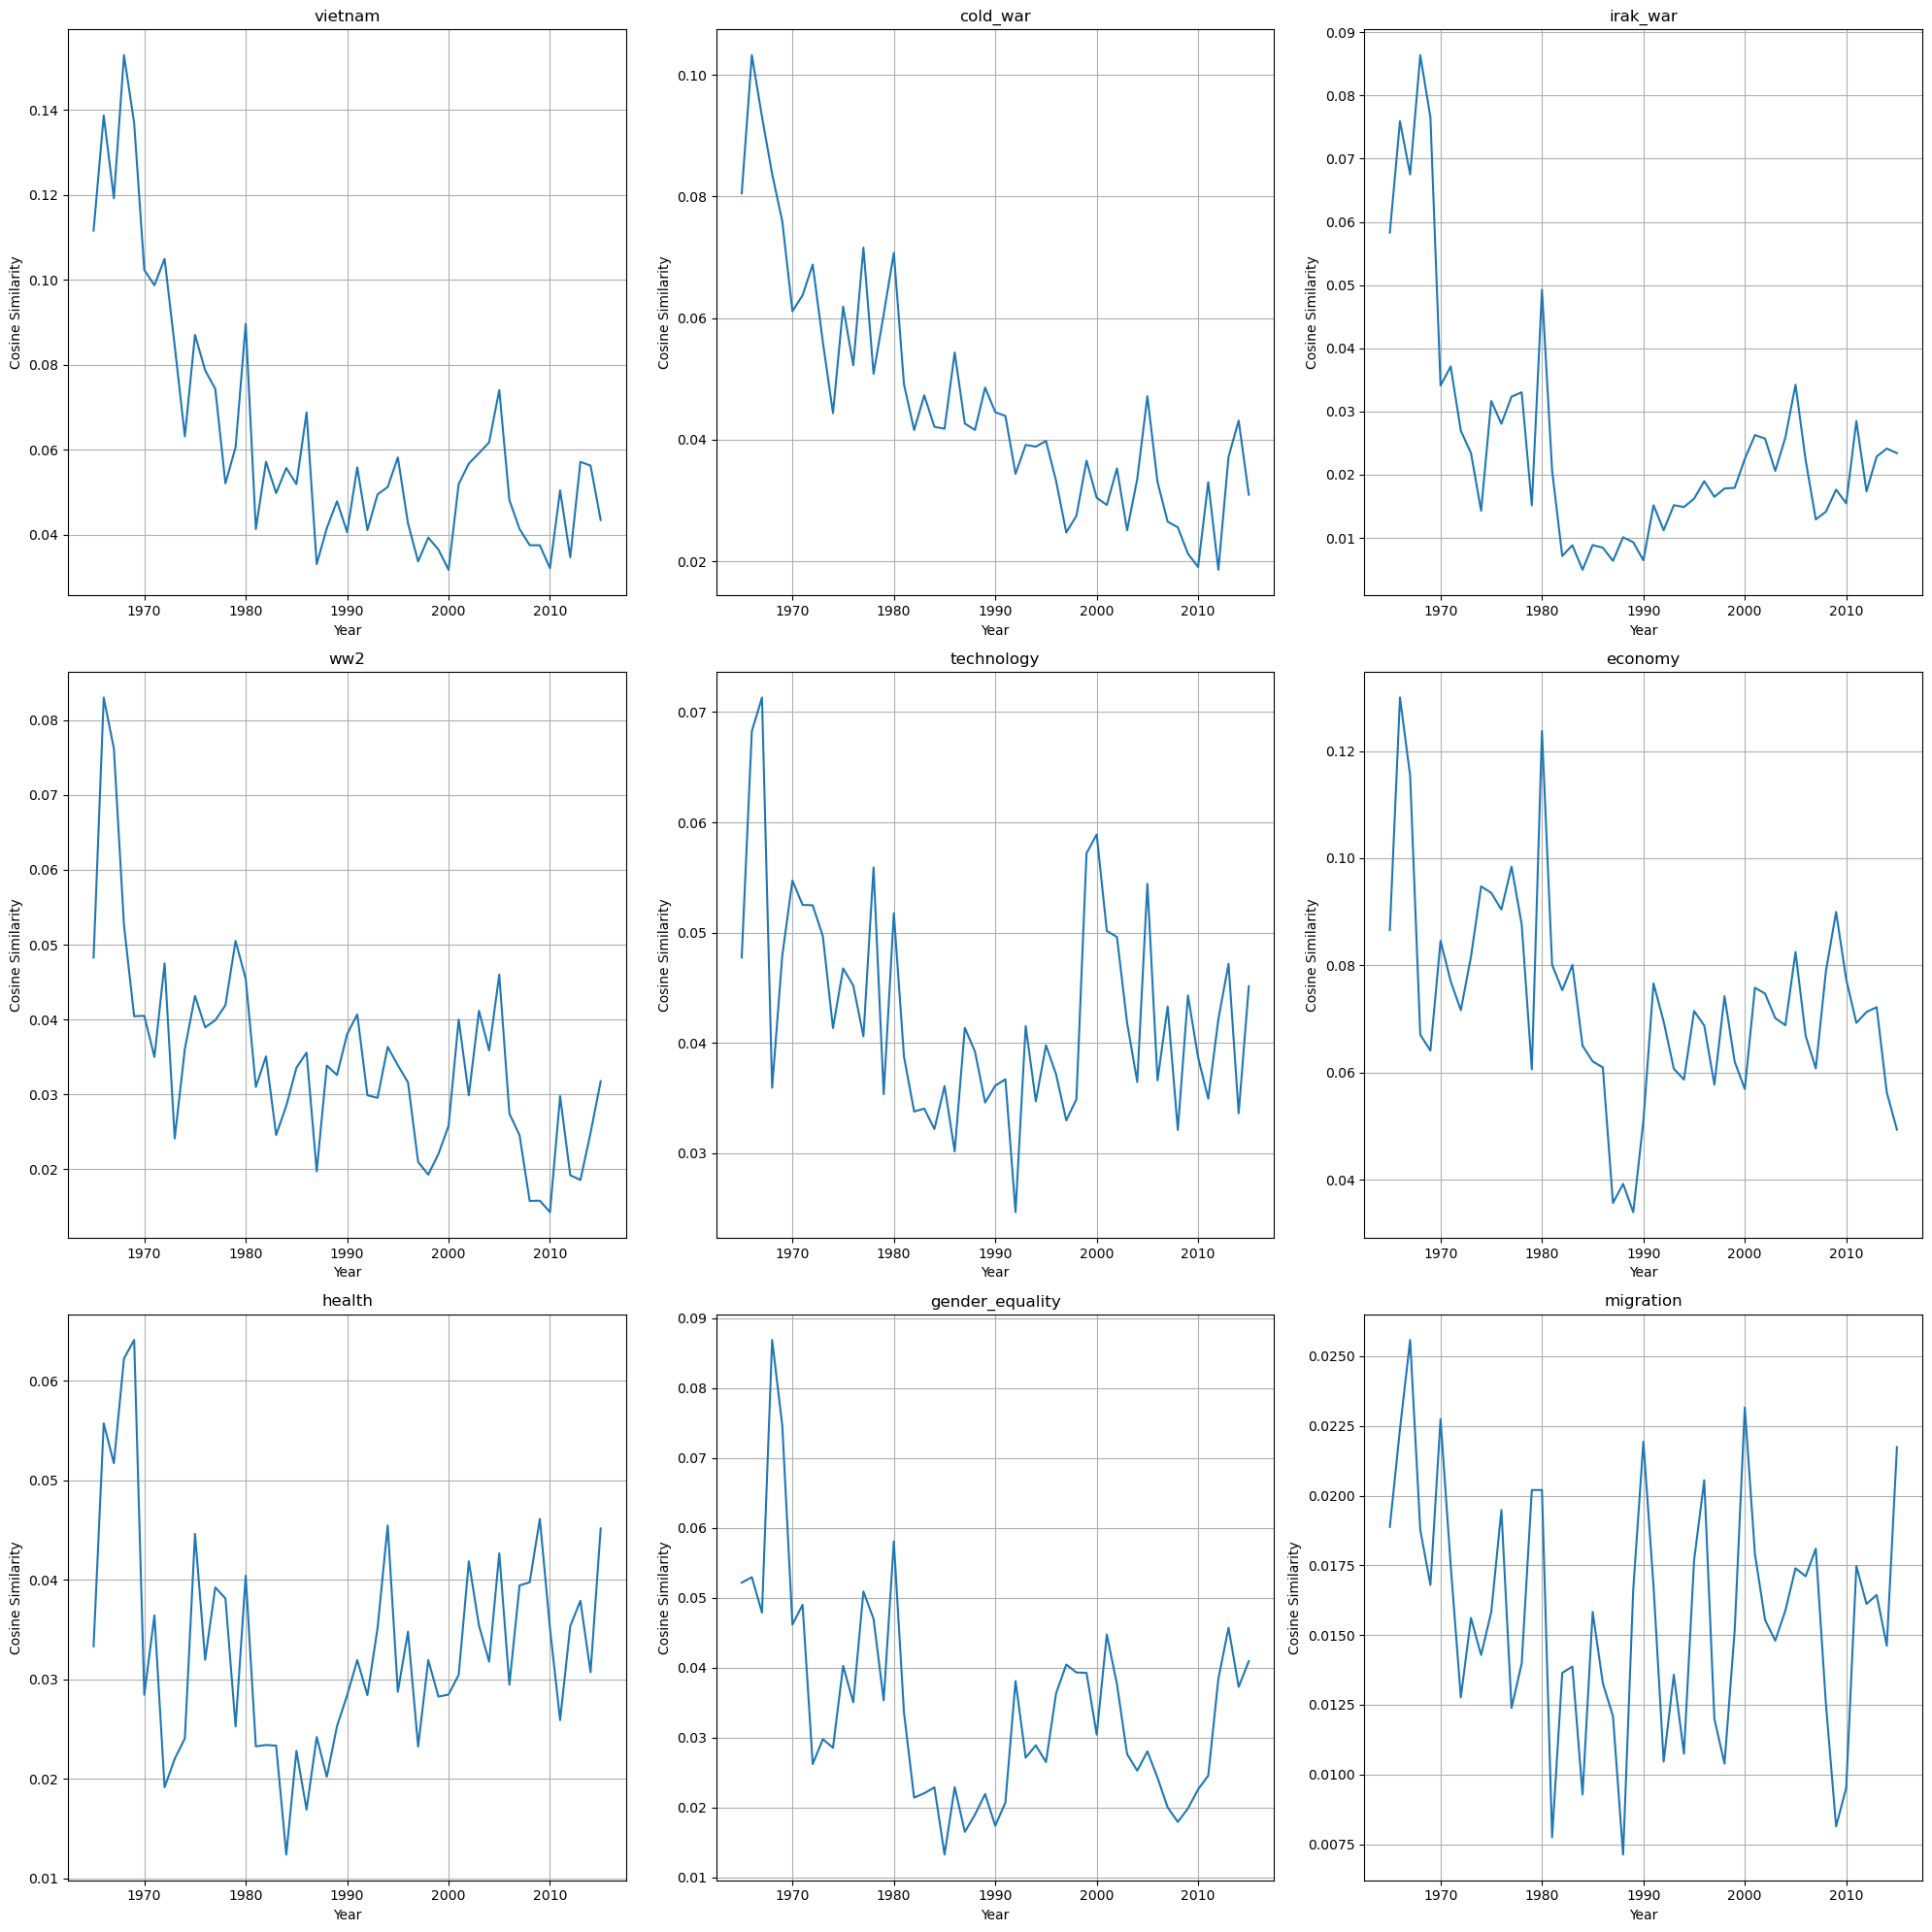

In [10]:
# Number of articles per year
articles_per_year = filtered_ddf['year'].value_counts().compute()
# Plot the cosine similarity for each query over time

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i, column in enumerate(column_names):
    row = i // 3
    col = i % 3
    # Sum the boolean values for each year
    cosine_similarity_df_bool_grouped = cosine_similarity_df_bool.groupby('year').sum()
    # Normalize the values by the number of articles in the year
    cosine_similarity_df_bool_grouped = cosine_similarity_df_bool_grouped.div(articles_per_year, axis=0)
    ax[row, col].plot(cosine_similarity_df_bool_grouped.index, cosine_similarity_df_bool_grouped[column])
    ax[row, col].set_title(column)
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Cosine Similarity')
    ax[row, col].grid()
plt.tight_layout()

plt.savefig('cosine_similarity_news.png')
plt.show()